In [ ]:
import os
from collections import defaultdict
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit

from prepro_script import *  # Imports all functions from prepro_script.py

random.seed(42)
np.random.seed(42)


def binarize_deauville(score):
    try:
        s = float(score)
    except:
        return None
    # Scores <= 3 become 0, scores >= 4 become 1
    if s <= 3:
        return 0
    elif s >= 4:
        return 1
    else:
        return None


In [28]:


#############################################
# 1. Load mapping from Excel: study_id -> patient_id, target, and lesion localization
#############################################
mapping_excel_path = r"/home/mezher/Documents/Deauville_DeepLearning/splitting/1. DeepDeauville Excel complété et anonymisé.xlsx"
df_mapping = pd.read_excel(mapping_excel_path)
# Create mapping dictionaries. Adjust column names as needed.
study_to_pid = dict(zip(df_mapping['SubjectCode'], df_mapping['PID']))
study_to_target = dict(zip(df_mapping['SubjectCode'], df_mapping['Deauville score ']))
study_to_target = {k: binarize_deauville(v) for k, v in study_to_target.items()}
study_to_localization = dict(zip(df_mapping['SubjectCode'], df_mapping['Lesion localisation ']))





In [29]:
#############################################
# 1. Functions to load PET series and study data
#############################################

def load_pet_series(modality_path):
    """
    Load all PET DICOM files from a series folder, group them by SeriesInstanceUID,
    sort by InstanceNumber, and stack them into a 3D NumPy array.
    
    Parameters:
      modality_path (str): Path to the PET series folder.
    
    Returns:
      dict: Mapping from series UID to a dict containing:
            - 'volume': 3D NumPy array (raw pixel data)
            - 'metadata_list': List of DICOM datasets for each slice.
    """
    series_dict = defaultdict(list)
    
    if not os.path.exists(modality_path):
        print(f"❌ ERROR: Folder '{modality_path}' does not exist!")
        return {}
    
    files = os.listdir(modality_path)
    for file in files:
        file_path = os.path.join(modality_path, file)
        if os.path.isfile(file_path):
            try:
                ds = pydicom.dcmread(file_path)
                # If TransferSyntaxUID is missing, assign the default for Explicit VR Little Endian.
                if not hasattr(ds, "file_meta"):
                    ds.file_meta = pydicom.dataset.FileMetaDataset()
                if not hasattr(ds.file_meta, "TransferSyntaxUID"):
                    ds.file_meta.TransferSyntaxUID = "1.2.840.10008.1.2.1"
                    
                series_id = ds.get("SeriesInstanceUID", None)
                if series_id is None:
                    continue
                series_dict[series_id].append(ds)
            except Exception as e:
                print(f"❌ ERROR reading {file_path}: {e}")
    
    series_volumes = {}
    for series_id, ds_list in series_dict.items():
        ds_list.sort(key=lambda s: int(s.get("InstanceNumber", 0)))
        try:
            volume = np.stack([s.pixel_array for s in ds_list])
            series_volumes[series_id] = {"volume": volume, "metadata_list": ds_list}
        except Exception as e:
            print(f"❌ ERROR stacking slices for series {series_id}: {e}")
    return series_volumes

def load_all_studies_data(data_dir, modality_prefix="PT"):
    """
    Load PET data from all study folders in the specified PET directory.
    
    Each study folder is expected to have a name starting with "DeepDeauville"
    (e.g., "DeepDeauville0001") and to contain one series folder whose name starts with the given modality_prefix.
    
    Parameters:
      data_dir (str): Path to the main PET folder.
      modality_prefix (str): The prefix of the series folder to search for (default: "PT").
    
    Returns:
      dict: Mapping from study ID (folder name) to the series data loaded from that study.
    """
    all_studies_data = {}
    for study_folder in os.listdir(data_dir):
        study_path = os.path.join(data_dir, study_folder)
        if os.path.isdir(study_path) and study_folder.startswith("DeepDeauville"):
            print(f"Processing study folder: {study_folder}")
            series_folder_found = False
            # Look for a series folder starting with the modality_prefix.
            for subfolder in os.listdir(study_path):
                subfolder_path = os.path.join(study_path, subfolder)
                if os.path.isdir(subfolder_path) and subfolder.startswith(modality_prefix):
                    series_data = load_pet_series(subfolder_path)
                    if series_data:
                        all_studies_data[study_folder] = series_data
                        series_folder_found = True
                    else:
                        print(f"❌ No valid series found in {subfolder_path}")
                    break  # Assuming one series per study.
            if not series_folder_found:
                print(f"❌ No series folder starting with '{modality_prefix}' found in study {study_folder}")
    return all_studies_data



In [30]:
#############################################
# 3. Load all study data and reorganize by patient
#############################################
data_dir = r"/home/mezher/Documents/Deauville_DeepLearning/PET"
all_study_data = load_all_studies_data(data_dir, modality_prefix="PT")

# Build a dictionary mapping patient_id to their studies.
all_patient_data = {}
for study_id, series_data in all_study_data.items():
    pid = study_to_pid.get(study_id, None)
    if pid is None:
        print(f"Warning: Study {study_id} not found in mapping. Skipping.")
        continue
    if pid not in all_patient_data:
        all_patient_data[pid] = {}
    all_patient_data[pid][study_id] = series_data

Processing study folder: DeepDeauville 1378
Processing study folder: DeepDeauville 0203


KeyboardInterrupt: 

In [ ]:
#############################################
# 4. Perform Patient-Level Split using GroupShuffleSplit
#############################################
patient_ids = list(all_patient_data.keys())
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=40)
train_idx, test_idx = next(gss.split(patient_ids, groups=patient_ids))
train_patient_ids = [patient_ids[i] for i in train_idx]
test_patient_ids = [patient_ids[i] for i in test_idx]

train_data = {pid: all_patient_data[pid] for pid in train_patient_ids}
test_data = {pid: all_patient_data[pid] for pid in test_patient_ids}


In [ ]:

# #############################################
# # Create Train/Test DataFrames from the Mapping
# #############################################
# # Filter df_mapping on patient IDs for train and test splits
# train_df = df_mapping[df_mapping['PID'].isin(train_patient_ids)].copy()
# test_df = df_mapping[df_mapping['PID'].isin(test_patient_ids)].copy()

# # Create the binary Deauville column (if not already present)
# train_df['Deauville_binary'] = train_df['Deauville score '].apply(binarize_deauville)
# test_df['Deauville_binary'] = test_df['Deauville score '].apply(binarize_deauville)

# # --- Create AgeGroup Column based on "Age Exam" ---
# bins = [0, 30, 45, 60, 75, 120]  # Define bins with an upper bound of 120
# labels = ['<30', '30-44', '45-59', '60-74', '75+']
# train_df['AgeGroup'] = pd.cut(train_df['Age Exam'], bins=bins, labels=labels, right=False)
# test_df['AgeGroup'] = pd.cut(test_df['Age Exam'], bins=bins, labels=labels, right=False)

# #############################################
# # Visualize Distribution with Countplots
# #############################################
# # List of columns to visualize (ensure these columns exist in your mapping Excel)
# strat_columns = [
#     "Sexe",
#     "AgeGroup",
#     "Deauville_binary",
#     "Deauville score ",
#     "Line of treatment ",
#     "Actual problem"
# ]

# for col in strat_columns:
#     print(f"Train distribution for {col}:")
#     print(train_df[col].value_counts(normalize=True))
#     print(f"\nTest distribution for {col}:")
#     print(test_df[col].value_counts(normalize=True))
#     print("\n" + "-"*50 + "\n")
    
# # Loop over each column and create side-by-side countplots for train and test splits
# for col in strat_columns:
#     plt.figure(figsize=(12, 4))
    
#     # Plot for the train set
#     plt.subplot(1, 2, 1)
#     sns.countplot(x=col, data=train_df)
#     plt.title(f"Train: {col}")
#     plt.xticks(rotation=45)
    
#     # Plot for the test set
#     plt.subplot(1, 2, 2)
#     sns.countplot(x=col, data=test_df)
#     plt.title(f"Test: {col}")
#     plt.xticks(rotation=45)
    
#     plt.tight_layout()
#     plt.show()
    

NameError: name 'df_mapping' is not defined

In [ ]:
import random
all_scan_list = []
global_scan_id = 0
num_splits = 20  # Number of bootstrap splits

# Pre-compute bootstrap splits at the patient level for training data.
# Each patient will have a consistent bootstrap assignment across all their studies.
bootstrap_splits_by_patient = {
    pid: {f"split{split}": ("train" if random.random() < 0.8 else "val") for split in range(num_splits)}
    for pid in train_patient_ids
}

# Process training data using the patient-level bootstrap assignments
for pid, studies in train_data.items():
    # Retrieve the pre-computed bootstrap splits for this patient.
    bootstrap_splits = bootstrap_splits_by_patient[pid]
    for study_id, series_dict in studies.items():
        # Extract target values from the mapping.
        target = study_to_target.get(study_id, None)
        target_loc = study_to_localization.get(study_id, None)
        for series_uid, series_data in series_dict.items():
            processed_images = preprocess_pet_series(series_data)
            mip_coronal = processed_images["mip_coronal"]
            mip_sagittal = processed_images["mip_sagittal"]
            filename_coronal = f"{study_id}_cor.npy"
            filename_sagittal = f"{study_id}_sag.npy"
            image_dir = os.path.join(os.getcwd(), "images")
            os.makedirs(image_dir, exist_ok=True)
            np.save(os.path.join(image_dir, filename_coronal), mip_coronal.astype(np.float32))
            np.save(os.path.join(image_dir, filename_sagittal), mip_sagittal.astype(np.float32))
            for mip_view, filename, matrix_size in zip(
                ["coronal", "sagittal"],
                [filename_coronal, filename_sagittal],
                [(mip_coronal.shape[0], mip_coronal.shape[1]),
                 (mip_sagittal.shape[0], mip_sagittal.shape[1])]
            ):
                row = {
                    "patient_id": pid,
                    "study_id": study_id,
                    "scan_id": global_scan_id,
                    "filename": os.path.join("images", filename),
                    "matrix_size_1": matrix_size[0],
                    "matrix_size_2": matrix_size[1],
                    "target": target,
                    "target_loc": target_loc
                }
                # Use the patient-level bootstrap splits for each row.
                row.update(bootstrap_splits)
                all_scan_list.append(row)
            global_scan_id += 1

# Process test data (all splits set to "test")
for pid, studies in test_data.items():
    for study_id, series_dict in studies.items():
        target = study_to_target.get(study_id, None)
        target_loc = study_to_localization.get(study_id, None)
        for series_uid, series_data in series_dict.items():
            processed_images = preprocess_pet_series(series_data)
            mip_coronal = processed_images["mip_coronal"]
            mip_sagittal = processed_images["mip_sagittal"]
            bootstrap_splits = {f"split{split}": "test" for split in range(num_splits)}
            filename_coronal = f"{study_id}_cor.npy"
            filename_sagittal = f"{study_id}_sag.npy"
            image_dir = os.path.join(os.getcwd(), "images")
            os.makedirs(image_dir, exist_ok=True)
            np.save(os.path.join(image_dir, filename_coronal), mip_coronal.astype(np.float32))
            np.save(os.path.join(image_dir, filename_sagittal), mip_sagittal.astype(np.float32))
            for mip_view, filename, matrix_size in zip(
                ["coronal", "sagittal"],
                [filename_coronal, filename_sagittal],
                [(mip_coronal.shape[0], mip_coronal.shape[1]),
                 (mip_sagittal.shape[0], mip_sagittal.shape[1])]
            ):
                row = {
                    "patient_id": pid,
                    "study_id": study_id,
                    "scan_id": global_scan_id,
                    "filename": os.path.join("images", filename),
                    "matrix_size_1": matrix_size[0],
                    "matrix_size_2": matrix_size[1],
                    "target": target,
                    "target_loc": target_loc
                }
                row.update(bootstrap_splits)
                all_scan_list.append(row)
            global_scan_id += 1

df_final = pd.DataFrame(all_scan_list)
print(df_final.head())
df_final.to_csv("data.csv", index=False)


---- SUV Conversion Debug Info ----
Max Rescale Slope  : 7.56748
Mean Rescale Slope : 0.788965702341137
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 353740000.0
Radionuclide Half-Life (s): 6586.2001953125
Injection Time: 2021-10-04 09:10:00
Series Time: 2021-10-04 10:11:12
Patient Weight (kg): 92.0
Decay Correction Factor: 0.6794647615638233
Max activity concentration (Bq/ml): 247963.61716
Corrected Dose (Bq): 240353864.75558686
Max SUV value calculated: 94.91277705027929
------------------------------------
SUV volume shape before resampling: (299, 192, 192)
Original Spacing: (2.734375, 2.734375, 3.27)
Original Size: (192, 192, 299)
New Spacing: [3.27, 3.27, 3.27]
Computed New Size: [161, 161, 299]
Resampled SUV Volume shape: (299, 161, 161)
Final SUV Volume shape after optional cropping: (299, 161, 161)
---- SUV Conversion Debug Info ----
Max Rescale Slope  : 5.26957
Mean Rescale Slope : 0.5175839791122716
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 258690000

In [11]:
import pandas as pd

# Load your original data.csv
df = pd.read_csv("data.csv")

# 1. Calculate frequency of each Lesion localisation
loc_freq = df["target_loc"].value_counts()

# 2. Identify localizations that occur at least 38 times
localizations_kept = loc_freq[loc_freq >= 38].index
localizations_removed = loc_freq[loc_freq < 38].index

# 3. Filter the DataFrame to keep only rows whose localizations are in localizations_kept
df_filtered = df[df["target_loc"].isin(localizations_kept)]

# 4. Calculate how many images were removed and how many are kept
num_removed = len(df) - len(df_filtered)
num_kept = len(df_filtered)

# 5. Print out the requested information for images
print(f"Localizations kept (>=38 occurrences): {len(localizations_kept)}")
print("They are:", list(localizations_kept))
print(f"Localizations removed (<38 occurrences): {len(localizations_removed)}")
print("They are:", list(localizations_removed))
print(f"Number of images removed: {num_removed}")
print(f"Number of images kept: {num_kept}")

# 6. Calculate unique patient counts
total_patients = df["patient_id"].nunique()
filtered_patients = df_filtered["patient_id"].nunique()
removed_patients = total_patients - filtered_patients

print(f"\nTotal unique patients in original data: {total_patients}")
print(f"Unique patients in filtered data: {filtered_patients}")
print(f"Number of patients removed: {removed_patients}")

# 7. Calculate unique study counts
total_studies = df["study_id"].nunique()
filtered_studies = df_filtered["study_id"].nunique()
removed_studies = total_studies - filtered_studies

print(f"\nTotal unique studies in original data: {total_studies}")
print(f"Unique studies in filtered data: {filtered_studies}")
print(f"Number of studies removed: {removed_studies}")


Localizations kept (>=38 occurrences): 14
They are: [51.0, 9.0, 28.0, 10.0, 6.0, 20.0, 11.0, 5.0, 8.0, 2.0, 1.0, 7.0, 25.0, 27.0]
Localizations removed (<38 occurrences): 29
They are: [13.0, 12.0, 21.0, 43.0, 18.0, 44.0, 39.0, 46.0, 33.0, 4.0, 22.0, 38.0, 3.0, 29.0, 23.0, 31.0, 48.0, 41.0, 30.0, 37.0, 34.0, 19.0, 24.0, 35.0, 14.0, 52.0, 36.0, 32.0, 26.0]
Number of images removed: 406
Number of images kept: 3168

Total unique patients in original data: 943
Unique patients in filtered data: 873
Number of patients removed: 70

Total unique studies in original data: 1787
Unique studies in filtered data: 1584
Number of studies removed: 203


In [10]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import random

# (Assuming df_filtered is already defined)

# Get unique patient IDs from the filtered DataFrame
patient_ids = df_filtered["patient_id"].unique()
print("Total unique patients:", len(patient_ids))

# Initialize GroupShuffleSplit with one split, 20% test size, and fixed random state for reproducibility
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Use the patient_ids both as the data and as the groups (each patient is its own group)
train_idx, test_idx = next(gss.split(patient_ids, groups=patient_ids))

# Select the patient IDs based on the indices
train_patient_ids = patient_ids[train_idx]
test_patient_ids = patient_ids[test_idx]

print("Number of patients in training set:", len(train_patient_ids))
print("Number of patients in test set:", len(test_patient_ids))

# Number of bootstrap splits to generate (for training patients)
num_splits = 20

# For each training patient, pre-compute bootstrap splits.
bootstrap_splits_by_patient = {
    pid: {f"split{split}": ("train" if random.random() < 0.8 else "val")
          for split in range(num_splits)}
    for pid in train_patient_ids
}

# For test patients, all splits are set to "test"
bootstrap_splits_by_patient_test = {
    pid: {f"split{split}": "test" for split in range(num_splits)}
    for pid in test_patient_ids
}

# Merge the two dictionaries
bootstrap_splits_by_patient.update(bootstrap_splits_by_patient_test)

# Assign the bootstrap splits to each row in df_filtered based on patient_id.
def assign_bootstrap(row):
    pid = row["patient_id"]
    splits = bootstrap_splits_by_patient.get(pid, {})
    for key, value in splits.items():
        row[key] = value
    return row

df_resplit = df_filtered.apply(assign_bootstrap, axis=1)

# Add a column to indicate overall set ("train" or "test") at the patient level
df_resplit["set"] = df_resplit["patient_id"].apply(lambda pid: "train" if pid in train_patient_ids else "test")

# Print summary information for images
num_train = df_resplit[df_resplit["set"]=="train"].shape[0]
num_test = df_resplit[df_resplit["set"]=="test"].shape[0]
print("Total images in filtered data:", len(df_filtered))
print("Number of images in training set:", num_train)
print("Number of images in test set:", num_test)
print("Localizations still present:", df_resplit["target_loc"].unique())

# Print unique study counts using the study_id column
num_studies_total = df_resplit["study_id"].nunique()
num_studies_train = df_resplit[df_resplit["set"]=="train"]["study_id"].nunique()
num_studies_test = df_resplit[df_resplit["set"]=="test"]["study_id"].nunique()
print("Total unique studies in filtered data:", num_studies_total)
print("Number of studies in training set:", num_studies_train)
print("Number of studies in test set:", num_studies_test)

# Optionally, save the new resplit CSV file
df_resplit.to_csv("data_resplit.csv", index=False)


Total unique patients: 873
Number of patients in training set: 698
Number of patients in test set: 175
Total images in filtered data: 3168
Number of images in training set: 2556
Number of images in test set: 612
Localizations still present: [51.  8.  9. 11. 20.  7. 10.  6. 28.  5. 27.  2. 25.  1.]
Total unique studies in filtered data: 1584
Number of studies in training set: 1278
Number of studies in test set: 306


Train set - Distribution of target_loc:
target_loc
51.0    1438
9.0      202
10.0     124
28.0     120
6.0       94
5.0       92
20.0      90
11.0      86
1.0       72
8.0       70
2.0       62
7.0       46
27.0      34
25.0      26
Name: count, dtype: int64

Train set - Normalized distribution:
target_loc
51.0    0.562598
9.0     0.079030
10.0    0.048513
28.0    0.046948
6.0     0.036776
5.0     0.035994
20.0    0.035211
11.0    0.033646
1.0     0.028169
8.0     0.027387
2.0     0.024257
7.0     0.017997
27.0    0.013302
25.0    0.010172
Name: proportion, dtype: float64

Test set - Distribution of target_loc:
target_loc
51.0    354
9.0      66
28.0     34
20.0     24
6.0      24
11.0     24
10.0     18
7.0      14
2.0      14
25.0     12
5.0      10
8.0      10
1.0       4
27.0      4
Name: count, dtype: int64

Test set - Normalized distribution:
target_loc
51.0    0.578431
9.0     0.107843
28.0    0.055556
20.0    0.039216
6.0     0.039216
11.0    0.039216
10.0    0.029412
7.0     0

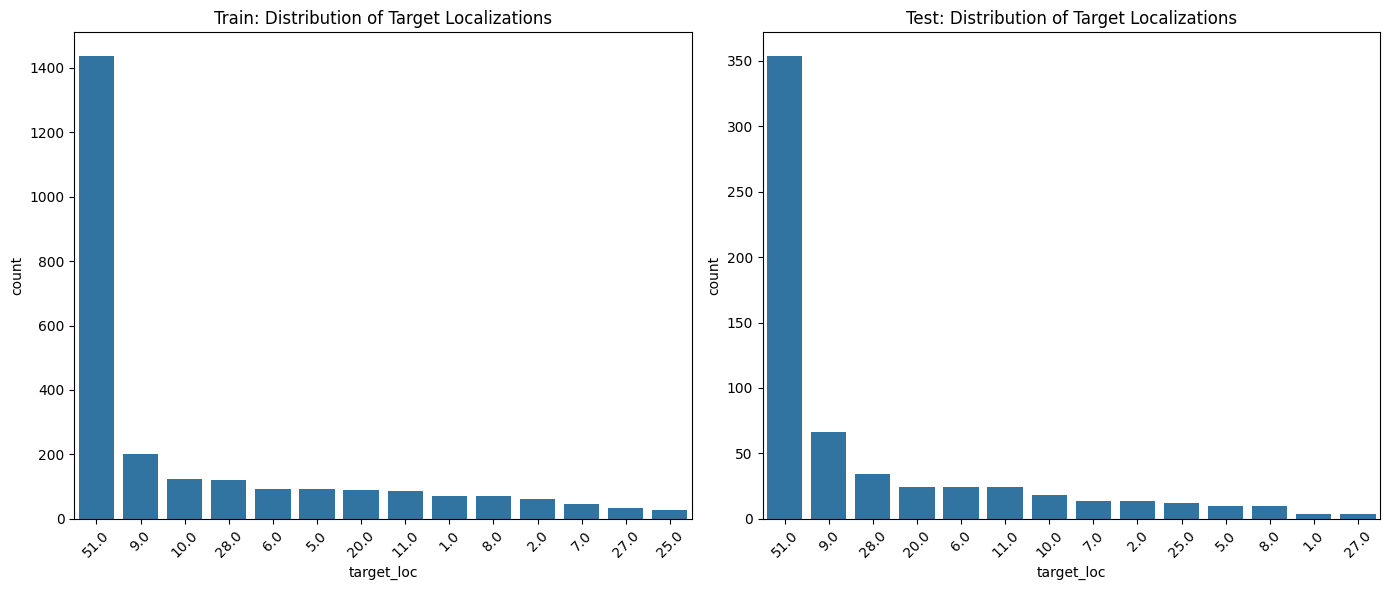

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split into train and test sets based on the 'set' column
train_df = df_resplit[df_resplit["set"] == "train"].copy()
test_df = df_resplit[df_resplit["set"] == "test"].copy()

# Print out the distribution of lesion localizations in train and test sets
print("Train set - Distribution of target_loc:")
print(train_df["target_loc"].value_counts())
print("\nTrain set - Normalized distribution:")
print(train_df["target_loc"].value_counts(normalize=True))

print("\nTest set - Distribution of target_loc:")
print(test_df["target_loc"].value_counts())
print("\nTest set - Normalized distribution:")
print(test_df["target_loc"].value_counts(normalize=True))

# Plot countplots for target localizations for both train and test sets side-by-side
plt.figure(figsize=(14, 6))

# Countplot for training set
plt.subplot(1, 2, 1)
sns.countplot(x="target_loc", data=train_df, order=train_df["target_loc"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Train: Distribution of Target Localizations")

# Countplot for test set
plt.subplot(1, 2, 2)
sns.countplot(x="target_loc", data=test_df, order=test_df["target_loc"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Test: Distribution of Target Localizations")

plt.tight_layout()
plt.show()


Unique studies in processed data: 1584
Mapping file studies after filtering: 1584
=== Train mapping - Distribution for Sexe ===
Sexe
H    740
F    538
Name: count, dtype: int64
Normalized:
Sexe
H    0.57903
F    0.42097
Name: proportion, dtype: float64

=== Test mapping - Distribution for Sexe ===
Sexe
H    193
F    113
Name: count, dtype: int64
Normalized:
Sexe
H    0.630719
F    0.369281
Name: proportion, dtype: float64
--------------------------------------------------
=== Train mapping - Distribution for AgeGroup ===
AgeGroup
60-74    363
45-59    303
30-44    271
75+      175
<30      166
Name: count, dtype: int64
Normalized:
AgeGroup
60-74    0.284038
45-59    0.237089
30-44    0.212050
75+      0.136933
<30      0.129890
Name: proportion, dtype: float64

=== Test mapping - Distribution for AgeGroup ===
AgeGroup
30-44    81
45-59    79
60-74    77
75+      40
<30      29
Name: count, dtype: int64
Normalized:
AgeGroup
30-44    0.264706
45-59    0.258170
60-74    0.251634
75+      

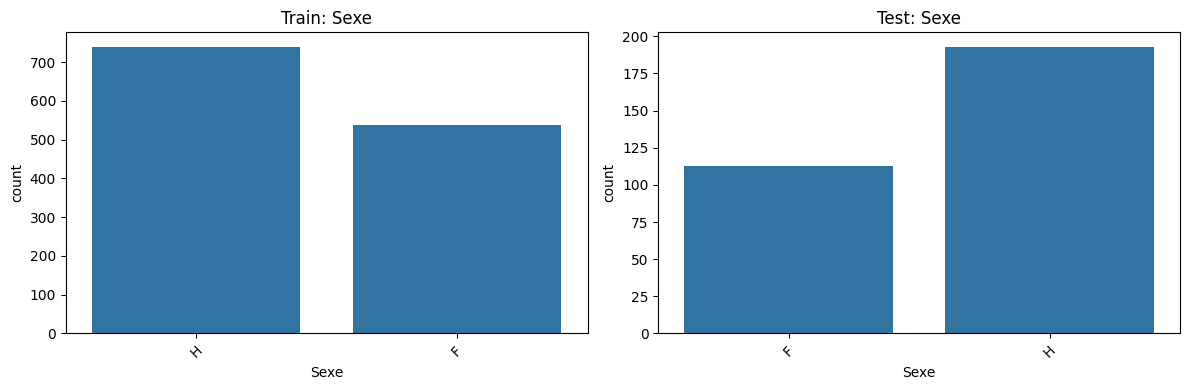

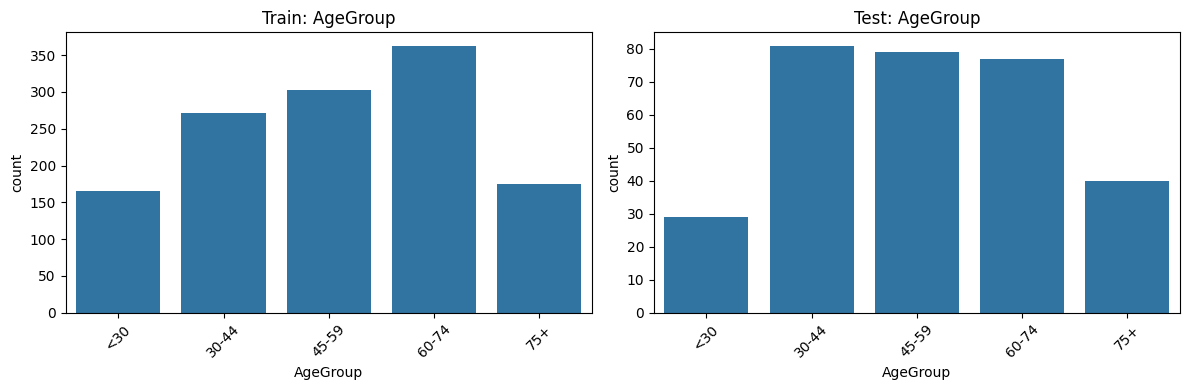

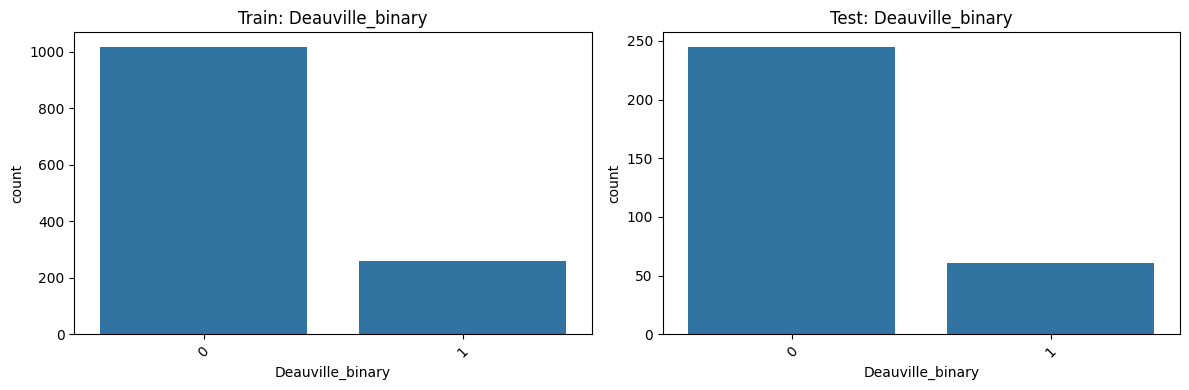

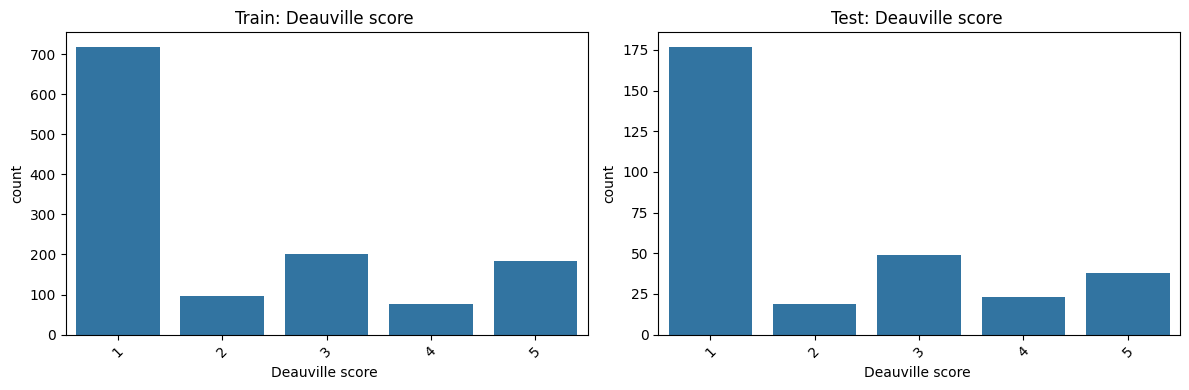

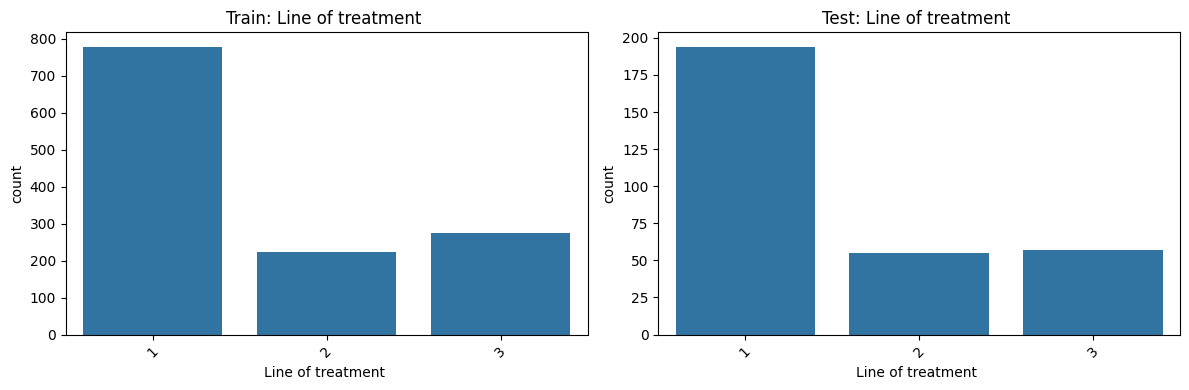

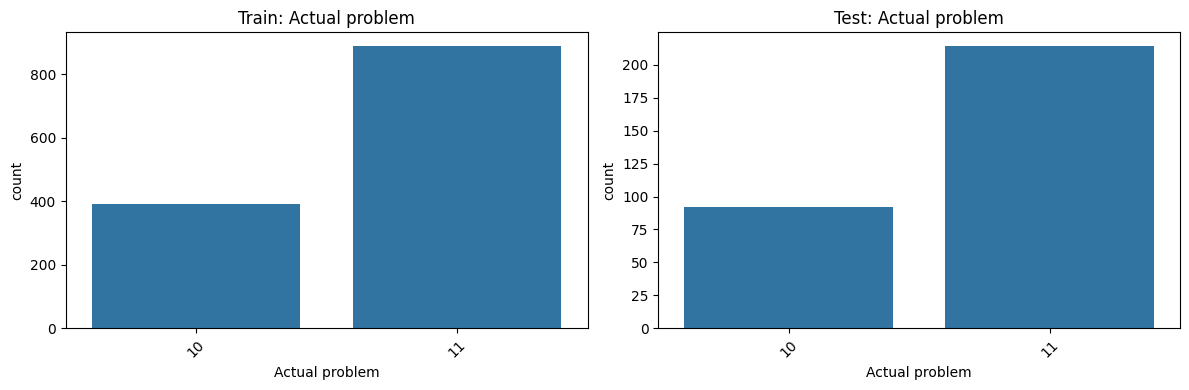

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load the resplit data (studies that were processed)
# -----------------------------
df_resplit = pd.read_csv("data_resplit.csv")
valid_study_ids = df_resplit["study_id"].unique()
print("Unique studies in processed data:", len(valid_study_ids))

# -----------------------------
# Load mapping file with extra covariates
# -----------------------------
mapping_excel_path = r"/home/mezher/Documents/Deauville_DeepLearning/splitting/1. DeepDeauville Excel complété et anonymisé.xlsx"
df_mapping = pd.read_excel(mapping_excel_path)

# Filter the mapping file to keep only studies included in data_resplit.csv.
# In your mapping file, each study is identified by 'SubjectCode'
df_mapping_included = df_mapping[df_mapping['SubjectCode'].isin(valid_study_ids)].copy()
print("Mapping file studies after filtering:", df_mapping_included.shape[0])

# Define the binarization function (if not already defined)
def binarize_deauville(score):
    try:
        s = float(score)
    except:
        return None
    # Scores <= 3 become 0, scores >= 4 become 1
    if s <= 3:
        return 0
    elif s >= 4:
        return 1
    else:
        return None

# Create additional columns in the mapping DataFrame.
df_mapping_included['Deauville_binary'] = df_mapping_included['Deauville score '].apply(binarize_deauville)

# For Deauville score, ensure a categorical order of 1, 2, 3, 4, 5.
# (Remove any extra spaces from the column name for clarity)
deauville_col = "Deauville score "
df_mapping_included[deauville_col] = pd.to_numeric(df_mapping_included[deauville_col], errors='coerce')
df_mapping_included[deauville_col] = pd.Categorical(df_mapping_included[deauville_col],
                                                   categories=[1, 2, 3, 4, 5],
                                                   ordered=True)

# Similarly, for Deauville_binary, set order 0 then 1.
binary_col = "Deauville_binary"
df_mapping_included[binary_col] = pd.Categorical(df_mapping_included[binary_col],
                                                 categories=[0, 1],
                                                 ordered=True)

# Create AgeGroup based on "Age Exam" (adjust bins if needed)
bins = [0, 30, 45, 60, 75, 120]
labels = ['<30', '30-44', '45-59', '60-74', '75+']
df_mapping_included['AgeGroup'] = pd.cut(df_mapping_included['Age Exam'], bins=bins, labels=labels, right=False)

# -----------------------------
# Split the mapping DataFrame into train and test sets
# (Assuming train_patient_ids and test_patient_ids were already created earlier.)
# Note: Here, we use the 'PID' column in the mapping file to match the patients.
train_mapping = df_mapping_included[df_mapping_included['PID'].isin(train_patient_ids)].copy()
test_mapping = df_mapping_included[df_mapping_included['PID'].isin(test_patient_ids)].copy()

# Define the covariate columns to be visualized.
strat_columns = [
    "Sexe",
    "AgeGroup",
    binary_col,
    deauville_col,
    "Line of treatment ",
    "Actual problem"
]

# -----------------------------
# Print the distribution for each covariate.
# -----------------------------
for col in strat_columns:
    print(f"=== Train mapping - Distribution for {col} ===")
    print(train_mapping[col].value_counts())
    print("Normalized:")
    print(train_mapping[col].value_counts(normalize=True))
    print(f"\n=== Test mapping - Distribution for {col} ===")
    print(test_mapping[col].value_counts())
    print("Normalized:")
    print(test_mapping[col].value_counts(normalize=True))
    print("-" * 50)

# -----------------------------
# Plot side-by-side countplots for each covariate.
# -----------------------------
for col in strat_columns:
    plt.figure(figsize=(12, 4))
    
    # For Deauville score and binary columns, specify the fixed order.
    if col.strip() == deauville_col.strip():
        order = [1, 2, 3, 4, 5]
    elif col.strip() == binary_col.strip():
        order = [0, 1]
    else:
        order = None  # Use default order
    
    # Countplot for the train set.
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=train_mapping, order=order)
    plt.title(f"Train: {col}")
    plt.xticks(rotation=45)
    
    # Countplot for the test set.
    plt.subplot(1, 2, 2)
    sns.countplot(x=col, data=test_mapping, order=order)
    plt.title(f"Test: {col}")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


Found image files: ['DeepDeauville 1145_sag.npy', 'DeepDeauville 0703_sag.npy', 'DeepDeauville 0832_sag.npy', 'DeepDeauville 0778_sag.npy', 'DeepDeauville 0984_sag.npy', 'DeepDeauville 0871_cor.npy', 'DeepDeauville 1586_cor.npy', 'DeepDeauville 1636_cor.npy', 'DeepDeauville 1449_sag.npy', 'DeepDeauville 1584_sag.npy', 'DeepDeauville 1359_cor.npy', 'DeepDeauville 0533_sag.npy', 'DeepDeauville 0530_sag.npy', 'DeepDeauville 1024_cor.npy', 'DeepDeauville 0113_sag.npy', 'DeepDeauville 0798_cor.npy', 'DeepDeauville 1228_cor.npy', 'DeepDeauville 0792_cor.npy', 'DeepDeauville 0846_cor.npy', 'DeepDeauville 1174_cor.npy', 'DeepDeauville 1187_cor.npy', 'DeepDeauville 0747_cor.npy', 'DeepDeauville 1262_cor.npy', 'DeepDeauville 1399_cor.npy', 'DeepDeauville 1620_cor.npy', 'DeepDeauville 0360_cor.npy', 'DeepDeauville 1229_cor.npy', 'DeepDeauville 1767_sag.npy', 'DeepDeauville 0594_sag.npy', 'DeepDeauville 0771_sag.npy', 'DeepDeauville 1120_sag.npy', 'DeepDeauville 0890_sag.npy', 'DeepDeauville 1233_

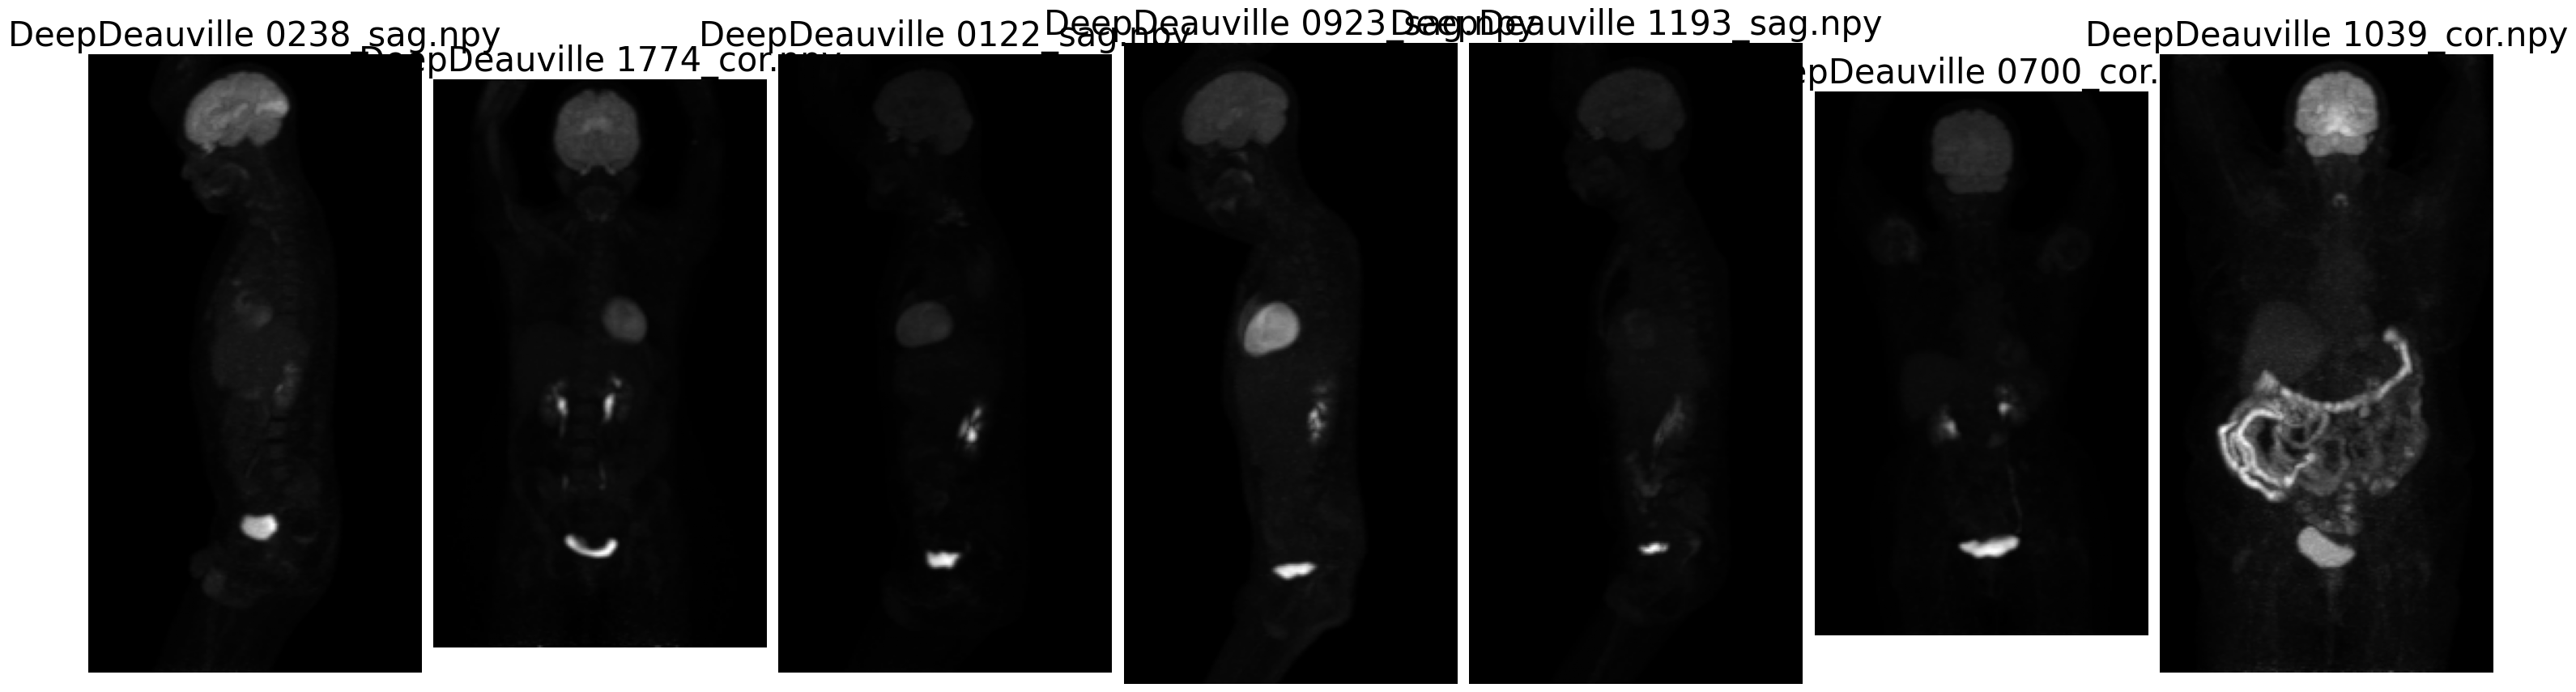

In [9]:


# Define the images folder (adjust if necessary)
images_dir = os.path.join(os.getcwd(), "images")

# List all .npy files in the folder
image_files = [f for f in os.listdir(images_dir) if f.endswith('.npy')]
print("Found image files:", image_files)

# Randomly select 5 images (if there are fewer than 5, select all)
selected_files = random.sample(image_files, min(7, len(image_files)))
print("Selected files:", selected_files)

# Plot the selected images in a row
fig, axes = plt.subplots(1, len(selected_files), figsize=(30, 10))
for ax, file in zip(axes, selected_files):
    img = np.load(os.path.join(images_dir, file))
    ax.imshow(img, cmap='gray')
    ax.set_title(file, fontsize=30)
    ax.axis("off")
plt.tight_layout()
plt.show()